# Melting and dissolution at a stagnation point

This notebook presents code to simulate melting and dissolution at a stagnation point using Dedalus.
We present a moving boundary problem and phase-field model formulation, and compare.

# Imports

In [1]:
import numpy as np
import dedalus.public as de
import matplotlib.pyplot as plt
import interpolation as ip
import field_tools as flt
import file_tools as flts
import h5py

import logging
root = logging.root
for h in root.handlers: h.setLevel("WARNING")
logger = logging.getLogger(__name__)

d = de.operators.differentiate
interp = de.operators.interpolate
integrate = de.operators.integrate

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
cmap = cm.get_cmap('Greys')
color = cmap(.5)

cdict_phi_grey = { 
    'red':  ((0.0, 1., 1.), (0.5, .7,.7), (1.0, color[0], color[0])),
    'green':((0.0, 1., 1.), (0.5, .7,.7), (1.0, color[0], color[0])),
    'blue': ((0.0, 1., 1.), (0.5, .7,.7), (1.0, color[0], color[0])),}
#     'alpha':((0.0, 1., 0.0), (0.1, 0.0, 0.0), (1.0, 1., 1.))  }
cmap_phi = LinearSegmentedColormap('cmap_phi', cdict_phi_grey)
plt.register_cmap(cmap=cmap_phi)

# Sharp simulation

## Code

In [3]:
def melting_salty_stag(ν,κ,μ,S,M,D,nx):
    xbasis = de.Chebyshev('x',nx,interval=(0,1),dealias=3/2)
    domain = de.Domain([xbasis],grid_dtype=np.float64)
    x, = domain.grids(domain.dealias)

    problem = de.NLBVP(domain,variables=['u','ux','uxx','v','Tl','Tlx','Ts','Tsx','C','Cx'])
    problem.meta[:]['x']['dirichlet'] = True
    problem.parameters['ν'] = ν
    problem.parameters['κ'] = κ
    problem.parameters['μ'] = μ
    problem.parameters['M'] = M
    problem.parameters['S'] = S
    problem.parameters['D'] = D

    problem.add_equation("dx(v) = 0")
    problem.add_equation('ux - dx(u) = 0')
    problem.add_equation('uxx- dx(ux) = 0')
    problem.add_equation("Tlx- dx(Tl) = 0")
    problem.add_equation("Tsx- dx(Ts) = 0")
    problem.add_equation("Cx - dx(C) = 0")
    problem.add_equation('ν*dx(uxx) = 1 + uxx*(u-v) - ux*ux')
    problem.add_equation("κ*dx(Tlx) = (u-v)*Tlx")
    problem.add_equation("κ*dx(Tsx) = -v*Tsx")
    problem.add_equation("μ*dx(Cx) = (u-v)*Cx")

    problem.add_bc('right(ux) = -1')
    problem.add_bc("right(Tl) = 1")
    problem.add_bc("right(C) = 1")
    problem.add_bc('left(u) = 0')
    problem.add_bc('left(ux) = 0')
    problem.add_bc("left(Tl + M*C) = 0")
    problem.add_bc("left(Tl) - right(Ts) = 0")
    problem.add_bc("κ*(left(Tlx) - right(Tsx)) + right(v)*S = 0")
    problem.add_bc("μ*left(Cx) = -left(v*C)")
    problem.add_bc("left(Ts) = -D")

    solver = problem.build_solver()
    u, ux, uxx, v, Tl, Tlx, Ts, Tsx, C, Cx = [solver.state[name] for name in problem.variables]
    for field in [u, ux, uxx, v, Tl, Tlx, Ts, Tsx, C, Cx]: field.set_scales(domain.dealias)

    u['g'], ux['g'], uxx['g'] = -x, -1, 0
    Tl['g'] = 1
    Ts['g'] = -D
    C['g'] = 1

    tolerance = 1e-10
    pert = solver.perturbations.data
    pert.fill(1+tolerance)

    while np.sum(np.abs(pert)) > tolerance:
        print(np.sum(np.abs(pert)))
        solver.newton_iteration()
    
    sim = {'x':x,'domain':domain,'ul':u,'ulx':ux,'ulxx':uxx,'v':v,'Tl':Tl,'Tlx':Tlx,'Ts':Ts,'Tsx':Tsx,'Cl':C,'Clx':Cx}
    params = {'S':S,'ν':ν,'κ':κ,'μ':μ,'M':M,'D':D}
    return sim, params

## Example plot

640.000000064
83.41072661654393
51.599072978595515
14.641920379184887
0.993516212819645
0.00239219424166628
4.626576220302729e-08


2020-06-26 17:50:49,903 matplotlib.font_manager 0/1 WARNING :: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


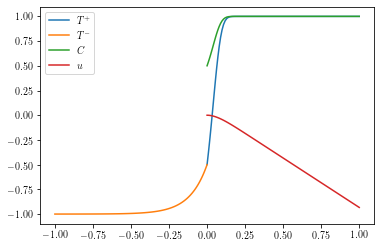

In [4]:
sim0, params0 = melting_salty_stag(1e-2,1e-3,1e-3,1,1,1,64)

plt.plot(sim0['x'],sim0['Tl']['g'],label='$T^+$')
plt.plot(sim0['x']-1,sim0['Ts']['g'],label='$T^-$')
plt.plot(sim0['x'],sim0['Cl']['g'],label='$C$')
plt.plot(sim0['x'],sim0['ul']['g'],label='$u$')
plt.legend()


# Phase-field model

## Code

In [5]:
def melting_salty_stag_phase(ν,κ,μ,S,M,D,ϵ,α,γ,η,n,δ=1e-3,thresh=500,guesses=None,damping=.1):
    xbasis = de.Chebyshev('x',n,interval=(0,1),dealias=2)
    domain = de.Domain([xbasis],grid_dtype=np.float64)
    x, = domain.grids(domain.dealias)

    problem = de.NLBVP(domain,variables=['ul','ulx','ulxx',
                                         'us','usx','usxx',
                                         'Tl','Tlx','Ts','Tsx',
                                         'Cl','Clx','Cs','Csx',
                                         'fl','flx','fs','fsx',
                                         'v'])
    problem.meta[:]['x']['dirichlet'] = True
    problem.parameters['ν'] = ν
    problem.parameters['κ'] = κ
    problem.parameters['μ'] = μ
    problem.parameters['S'] = S
    problem.parameters['M'] = M
    problem.parameters['D'] = D
    problem.parameters['eps'] = ϵ
    problem.parameters['α'] = α
    # problem.parameters['β'] = β
    problem.parameters['η'] = η
    problem.parameters['δ'] = δ
    problem.parameters['γ'] = γ

    problem.add_equation('κ*dx(Tlx) = ((1-fl)*ul - v)*Tlx + S*v*flx')
    problem.add_equation('κ*dx(Tsx) = ((1-fs)*us - v)*Tsx + S*v*fsx')
    problem.add_equation('μ*dx(Clx) = (ul - v)*Clx - dx(log(1-fl+δ))*(μ*Clx + v*Cl)')
    problem.add_equation('μ*dx(Csx) = (us - v)*Csx - dx(log(1-fs+δ))*(μ*Csx + v*Cs)')
    problem.add_equation('γ*dx(flx) = -α*v*flx + (γ/eps**2)*fl*(1-fl)*(1-2*fl) + fl*(1-fl)*(Tl+M*Cl)/eps')# 
    problem.add_equation('γ*dx(fsx) = -α*v*fsx + (γ/eps**2)*fs*(1-fs)*(1-2*fs) + fs*(1-fs)*(Ts+M*Cs)/eps')#
    problem.add_equation('ν*dx(ulxx) = 1 + ulxx*(ul-v) - ulx*ulx + fl*ulx/η')
    problem.add_equation('ν*dx(usxx) = 1 + usxx*(us-v) - usx*usx + fs*usx/η')
    problem.add_equation('Tlx - dx(Tl) = 0')
    problem.add_equation('Tsx - dx(Ts) = 0')
    problem.add_equation('Clx - dx(Cl) = 0')
    problem.add_equation('Csx - dx(Cs) = 0')
    problem.add_equation('flx - dx(fl) = 0')
    problem.add_equation('fsx - dx(fs) = 0')
    problem.add_equation('ulx - dx(ul) = 0')
    problem.add_equation('ulxx- dx(ulx)= 0')
    problem.add_equation('usx - dx(us) = 0')
    problem.add_equation('usxx- dx(usx)= 0')
    problem.add_equation('dx(v) = 0')

    problem.add_bc('right(Tl) = 1')
    problem.add_bc('right(Cl) = 1')
    problem.add_bc('right(fl) = 0')
    problem.add_bc('right(ulx) = -1')
    problem.add_bc('left(Tl) - right(Ts) = 0')
    problem.add_bc('left(Tlx)- right(Tsx) = 0')
    problem.add_bc('left(Cl) - right(Cs) = 0')
    problem.add_bc('left(Clx)- right(Csx) = 0')
    problem.add_bc('left(fl) - right(fs) = 0')
    problem.add_bc('left(flx)- right(fsx) = 0')
    problem.add_bc('left(ul) - right(us) = 0')
    problem.add_bc('left(ulx)- right(usx) = 0')
    problem.add_bc('left(ulxx)-right(usxx) = 0')
    problem.add_bc('left(fl) = 1/2')
    problem.add_bc('left(Ts) = -D')
    problem.add_bc('left(Cs) = 0')
    problem.add_bc('left(fs) = 1')
    problem.add_bc('left(us) = 0')
    problem.add_bc('left(usx) = 0')

    solver = problem.build_solver()

    fields = {}
    for a in problem.variables:
        fields[a] = solver.state[a]
        fields[a].set_scales(domain.dealias)
        fields[a]['g'] = 0
        
    fl,fs = fields['fl'], fields['fs']
    fl['g'] = (1/2)*(1-np.tanh(x/(2*ϵ)))
    fs['g'] = (1/2)*(1-np.tanh((x-1)/(2*ϵ)))    
    if guesses:
        for a in fields:
            fields[a]['g'] = ip.interp(guesses[a],x)
    else:
        sim0, params0 = melting_salty_stag(ν,κ,μ,S,M,D,128)
        ul0,Tl0,Ts0,Cl0,v0 = [sim0[f] for f in ['ul','Tl','Ts','Cl','v']]
        fields['ul']['g'] = ip.interp(ul0,x)
        fields['us']['g'] = 0
        fields['Tl']['g'] = ip.interp(Tl0,x)
        fields['Ts']['g'] = ip.interp(Ts0,x)
        fields['Cl']['g'] = ip.interp(Cl0,x)
        fields['Cs']['g'] = Cl0.interpolate(x='left')['g'][0]
        fields['v']['g'] = v0['g'][0]        
    for f in ['ul','us','ulx','usx','Tl','Ts','Cl','Cs']:
        fields[f+'x']['g'] = fields[f].differentiate('x')['g']

    tolerance = 1e-10
    pert = solver.perturbations.data
#     pert.fill(1+tolerance)
    res = 1#np.sum(np.abs(pert))

    while res > tolerance:
        solver.newton_iteration(damping=damping)
        res = np.sum(np.abs(pert))
        if res < thresh: damping = 1
        print(res)
    
    sim = {'x':x,'domain':domain}
    for field in fields: sim[field] = fields[field]
    params = {'S':S,'ν':ν,'κ':κ,'μ':μ,'M':M,'D':D,
              'ϵ':ϵ,'α':α,'γ':γ,'η':η}
    return sim, params

## Example plot

In [6]:
ν,κ,μ = 1e-1,1e-1,1e-1
S,N,D = 1,1,1
ϵ = 0.05
α = ϵ*(S/κ)*5/6
γ = 1
β = 4/2.648228
η = (β*ϵ)**2/ν
n = 64
δ = 2e-5

sim0, params0 = melting_salty_stag(ν,κ,μ,S,N,D,128)
sim1, params1 = melting_salty_stag_phase(ν,κ,μ,S,N,D,ϵ,α,γ,η,n,δ=δ,thresh=100)

1280.000000128
16.27129875022765
7.287382321082768
1.0174448706924408
0.0072425286694047354
5.790397485252977e-07
1280.000000128
16.27129875022765
7.287382321082768
1.0174448706924408
0.0072425286694047354
5.790397485252977e-07
19.12110751321836
17.19797573462303
0.7113159893771449
0.022001875894994534
3.2187429007077616e-06
2.148362044183664e-11


In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'legend.fontsize':10})

In [8]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [9]:
%config InlineBackend.figure_format = 'retina'

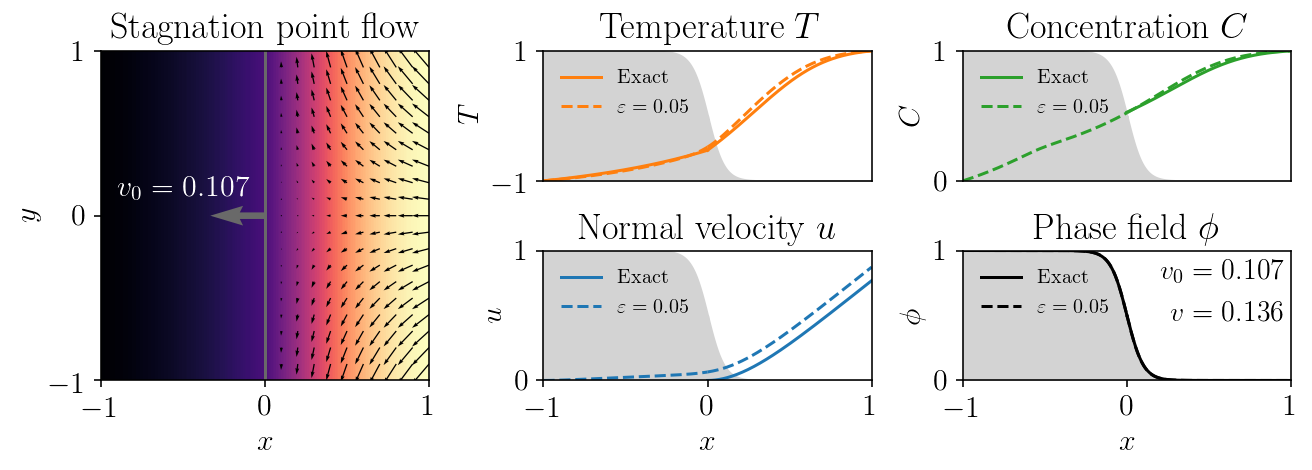

In [11]:
i = 1
fsize = 18
x0, Tl0, Ts0, Cl0, ul0 = [sim0[name] for name in ['x','Tl','Ts','Cl','ul']]
x, Tl, Ts, Cl, Cs, ul, us, fl, fs = [sim1[name] for name in ['x','Tl','Ts','Cl','Cs','ul','us','fl','fs']]
Lx = -1
fig = plt.figure(constrained_layout=True,figsize=(9,3.5*.9))
gs = fig.add_gridspec(2,3)
ax = {}
for i in range(2):
    for j in range(2):
        ax[i,j] = fig.add_subplot(gs[i,j+1])
lax = fig.add_subplot(gs[:,0])
xs = np.linspace(0,1,101)
ys = np.linspace(-1,1,201)
points = np.stack([np.abs(ys[::15]),ys[::15]]).T
xxs, yy = np.meshgrid(xs+Lx,ys,indexing='ij')
xxl, yy = np.meshgrid(xs,ys,indexing='ij')
u0l, v0l = ip.interp(ul0,xs)[:,None] + 0*yy, - ip.interp(ul0.differentiate('x'),xs)[:,None]*yy
T0l, T0s = ip.interp(Tl0,xs)[:,None] + 0*yy, ip.interp(Ts0,xs)[:,None] + 0*yy
speed = np.hypot(u0l,v0l)
# lax.streamplot(xs,ys,u0l.T,v0l.T,start_points=points,linewidth=4*speed.T/speed.max(),color='k')
sl = slice(None,None,10)
sel = (sl,sl)
lax.pcolormesh(xxl,yy,T0l,cmap='magma',vmin=-1,vmax=1)
cplot = lax.pcolormesh(xxs,yy,T0s,cmap='magma',vmin=-1,vmax=1)
lax.plot(0*ys,ys,'dimgray')#,linestyle='--')
lax.quiver(xxl[sel],yy[sel],u0l[sel],v0l[sel])
lax.quiver([0],[0], [-1],[0],color='dimgray',scale=6,width=0.02)
# plt.colorbar(cplot)
lax.set(yticks=[-1,0,1],xlabel='$x$',ylabel='$y$',title='Stagnation point flow')

# fig, ax = plt.subplots(2,2,figsize=(7,3.5),sharex=True)
ax[0,0].plot(x0,Tl0['g'],'C1',label='Exact')
ax[0,0].plot(x,Tl['g'],'C1--',label=f'$\\varepsilon = {ϵ:.2f}$')
ax[0,0].plot(x+Lx,Ts['g'],'C1--')
ax[0,0].plot(x0+Lx,Ts0['g'],'C1')
ax[0,0].fill_between(x,-1,2*fl['g']-1,color='lightgray')
ax[0,0].fill_between(x+Lx,-1,2*fs['g']-1,color='lightgray')
ax[0,0].set(xlim=[-1,1],ylim=[-1,1],xlabel='$x$',ylabel='$T$',title='Temperature $T$')
ax[0,0].legend(frameon=False)
ax[0,0].set(yticks=[-1,1])

ax[0,1].plot(x0,Cl0['g'],'C2',label='Exact')
ax[0,1].plot(x,Cl['g'],'C2--',label=f'$\\varepsilon = {ϵ:.2f}$')
ax[0,1].plot(x+Lx,Cs['g'],'C2--')
ax[0,1].fill_between(x,0,fl['g'],color='lightgray')
ax[0,1].fill_between(x+Lx,0,fs['g'],color='lightgray')
ax[0,1].set(xlim=[-1,1],ylim=[0,1],xlabel='$x$',ylabel='$C$',title='Concentration $C$')
ax[0,1].legend(loc='upper left',frameon=False)
ax[0,1].set(yticks=[0,1])

ax[1,0].plot(x0,-ul0['g'],'C0',label='Exact')
ax[1,0].plot(x,-ul['g'],'C0--',label=f'$\\varepsilon = {ϵ:.2f}$')
ax[1,0].plot(x+Lx,-us['g'],'C0--')
ax[1,0].fill_between(x,0,fl['g'],color='lightgray')
ax[1,0].fill_between(x+Lx,0,fs['g'],color='lightgray')
ax[1,0].set(xlim=[-1,1],ylim=[0,1],xlabel='$x$',ylabel='$u$',title='Normal velocity $u$')
ax[1,0].legend(frameon=False)
ax[1,0].set(yticks=[0,1])

fl0 = 0.5*(1-np.tanh((x0+Lx)/(2*ϵ)))
fs0 = 0.5*(1-np.tanh((x0)/(2*ϵ)))
ax[1,1].plot(x0+Lx,fl0,'k',label='Exact')
ax[1,1].plot(x,fl['g'],'k--',label=f'$\\varepsilon = {ϵ:.2f}$')
ax[1,1].plot(x+Lx,fs['g'],'k--')
ax[1,1].plot(x0,fs0,'k')
ax[1,1].fill_between(x,0,fl['g'],color='lightgray')
ax[1,1].fill_between(x+Lx,0,fs['g'],color='lightgray')
ax[1,1].set(xlim=[-1,1],ylim=[0,1],xlabel='$x$',ylabel=r'$\phi$',title='Phase field $\\phi$')
ax[1,1].legend(loc='upper left',frameon=False)
ax[1,1].set(yticks=[0,1])

ax[1,1].text(.95,.45,f'$v = {-sim1["v"]["g"][0]:.3f}$',horizontalalignment='right',fontsize=14)
ax[1,1].text(.95,.75,f'$v_0 = {-sim0["v"]["g"][0]:.3f}$',horizontalalignment='right',fontsize=14)
lax.text(-.9,.1,f'$v_0 = {-sim0["v"]["g"][0]:.3f}$',color='white')
for axi in {ax[0,0],ax[0,1]}: axi.set(xticks=[],xlabel='')

plt.savefig('melt-salt-flow-diagram.png',dpi=500,bbox_inches='tight')

## Convergence of optimal parameters

### Simulation parameters

In [ ]:
ν,κ,μ = 1e-1,1e-1,1e-1
S,M,D = 1,1,1
sim0, params0 = melting_salty_stag(ν,κ,μ,S,M,D,128)

β = (4/2.648228)
ϵs = np.logspace(-1,-3,7,base=10)
αs = ϵs*(S/κ)*(5/6)
γ = 1
ηs = (β*ϵs)**2/ν
ns = np.array([128,256,256,256,256,256,256])
δ = 2e-5

### Run simulations and store data

In [ ]:
# run simulations
sims, params = {},{}

ind = 0
sims[ind],params[ind] = melting_salty_stag_phase(ν,κ,μ,S,M,D,ϵs[ind],αs[ind],γ,ηs[ind],ns[ind],
                                             δ=δ,thresh=100)

for ind in range(1,len(ϵs)):
    sims[ind],params[ind] = melting_salty_stag_phase(ν,κ,μ,S,M,D,ϵs[ind],αs[ind],γ,ηs[ind],ns[ind],
                                             δ=δ,thresh=100)

### Calculate errors

In [ ]:
errors = {}
E1s = {}
Einfs = {}
dvs = {}

for i in range(len(ϵs)):
    errors[i],E1s[i],Einfs[i] = {},{},{}
    for f in ['ul','Tl','Ts','Cl']:
        errors[i][f] = sims[i]['domain'].new_field(scales=sims[i]['domain'].dealias)
        errors[i][f]['g'] = np.abs(sims[i][f]['g'] - ip.interp(sim0[f],sims[i]['x']))
        E1s[i][f] = errors[i][f].integrate()['g'][0]
        Einfs[i][f] = errors[i][f]['g'].max()
    dvs[i] = np.abs(sims[i]['v']['g'][0] - sim0['v']['g'][0])


### Plot convergence in $\varepsilon$

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(5,3))
dv = [dvs[i] for i in range(len(ϵs))]
colors = ['C0','C1','C3','C2']
markers = ['<','v','^','o']
labels = ['$u$','$T^+$','$T^-$','$C$']
keys = ['ul','Tl','Ts','Cl']
for i in [2,1,3,0]:
    color, label, f = colors[i],labels[i],keys[i]
    E1 = [E1s[i][f] for i in range(len(ϵs))]
    Einf = [Einfs[i][f] for i in range(len(ϵs))]
    ax[0].loglog(ϵs,E1,marker=markers[i],label=label,color=color)
    ax[1].loglog(ϵs,Einf,marker=markers[i],label=label,color=color)
ax[1].loglog(ϵs,dv,marker='s',label='$v$',color='C4')
for axi in ax:
    axi.plot(ϵs,ϵs,'--',color='gray',label='$\\varepsilon$')
    axi.plot(ϵs,ϵs**2,'--',color='black',label='$\\varepsilon^2$')
    axi.grid(True)
    axi.set_xlabel('$\\varepsilon$',fontsize=13)
ax[0].set_title('$L^1$ error',fontsize=13)    
ax[1].set_title('$L^\\infty$ error',fontsize=13)    
ax[0].set(xlim=[7e-4,1.5e-1],ylim=[6e-7,1.8],xticks=[1e-3,1e-2,1e-1],yticks=np.logspace(-6,0,7))
ax[1].set(xlim=[7e-4,1.5e-1],ylim=[6e-7,1.8],xticks=[1e-3,1e-2,1e-1],yticks=np.logspace(-6,0,7))
ax[1].legend(bbox_to_anchor=(1.05,1.),frameon=False,fontsize=13)
plt.tight_layout()
plt.savefig(f'melt-salt-flow-convergence.pdf',bbox_inches='tight')

## Optimal parameter sensitivity

### Set up simulation

In [ ]:
# Decrement the first non-zero element of an array
def decrement_single(inds):
    previous = []
    pre = True
    for i,ind in enumerate(inds):
        if ind > 0 and pre:
            previous.append(ind-1)
            pre = False
        else:
            previous.append(ind)
    return tuple(previous)

def prod(arr):
    if len(arr) == 1: return arr[0]
    else: return arr[0]*prod(arr[1:])

In [ ]:
ν,κ,μ = 1e-1,1e-1,1e-1
S,M,D = 1,1,1
sim0, params0 = melting_salty_stag(ν,κ,μ,S,M,D,128)

β = (4/2.648228)
ϵ = np.logspace(-2,-3,4,base=10)[None,None,:]
α = ϵ*(S/κ)*(5/6)*(np.logspace(-1,1,7,base=2)[None,:,None])
γ = 1
η = ((β*ϵ)**2/ν)*(np.logspace(-1,1,7,base=2)[:,None,None])
n = np.array([128,128,256,256])[None,None,:]
δ = 2e-5

b0 = 0*(ϵ + α + η + n).astype(int)

νs,κs,μs = ν+b0,κ+b0,μ+b0
Ss,Ms,Ds = S+b0,M+b0,D+b0
ϵs = ϵ + b0
αs = α + b0
γs = γ + b0
ηs = η + b0
ns = n + b0
δs = δ + b0

Ns = b0.shape
inds = np.indices(Ns).reshape(len(Ns),prod(Ns))
sims, params = {},{}

### Run simulations

In [ ]:
# Preliminary simulations
for i in range(0,4):
    ind = (0,0,i)
    sims[ind],params[ind] = melting_salty_stag_phase(νs[ind],κs[ind],μs[ind],Ss[ind],Ms[ind],Ds[ind],
                                                         ϵs[ind],αs[ind],γs[ind],ηs[ind],ns[ind],
                                                         δ=δs[ind],thresh=100)

# Remaining simulations (initialise from previous simulation)
for i in range(4,inds.shape[1]):
    ind = tuple(inds[:,i])
    g_ind = decrement_single(ind)
    sims[ind],params[ind] = melting_salty_stag_phase(νs[ind],κs[ind],μs[ind],Ss[ind],Ms[ind],Ds[ind],
                                                     ϵs[ind],αs[ind],γs[ind],ηs[ind],ns[ind],
                                                     guesses=sims[g_ind],δ=δs[ind],thresh=100)

### Calculate errors

In [ ]:
keys = list(sims[0,0,0].keys())

errors = {}
E1s = {}
Einfs = {}
dvs = {}
for key in keys[2:]: 
    errors[key] = {}
    E1s[key] = 0.0*b0
    Einfs[key] = 0.0*b0

for key in ['ul','Cl','Ts','Tl','v']:
    print(key)
    for i in range(inds.shape[1]):
        ind = tuple(inds[:,i])
        errors[key][ind] = sims[ind]['domain'].new_field(scales=sims[ind]['domain'].dealias)
        errors[key][ind]['g'] = np.abs(sims[ind][key]['g'] - ip.interp(sim0[key],sims[ind]['x']))
        E1s[key][ind] = errors[key][ind].integrate()['g'][0]
        Einfs[key][ind] = errors[key][ind]['g'].max()

### Save data

In [ ]:
βs = b

In [ ]:
simname = 'vary-alpha-beta-eps-big'
with h5py.File(f'salty-stag-{simname}.h5','w') as f:
    f['α'] = αs
#     f['β'] = βs
    f['ϵ'] = ϵs
    f['η'] = ηs
    f['γ'] = γs
    f['μ'] = μs
    f['ν'] = νs
    f['κ'] = κs
    f['δ'] = δs
    for key in ['ul','Cl','Ts','Tl','v']:
        f[f'E1/{key}'] = E1s[key]
        f[f'Einf/{key}'] = Einfs[key]        

### Load data

In [ ]:
import h5py
E1s, Einfs = {},{}
with h5py.File(f'salty-stag-{simname}.h5','r') as f:
    αs = f['α'][:]
#     βs = f['β'][:]
    ϵs = f['ϵ'][:]
    ηs = f['η'][:]
    γs = f['γ'][:]
    μs = f['μ'][:]
    νs = f['ν'][:]
    κs = f['κ'][:]
    δs = f['δ'][:]
#     f['x'] = np.array([[[sims[i,j,k]['x'] for i in range(Ns[0])] for j in range(Ns[1])] for k in range(Ns[2])])
#     keys = list(sims[0,0,0].keys())
#     for key in keys[2:]:
#         f[key] = np.array([[[sims[i,j,k][key]['g'] for i in range(Ns[0])] for j in range(Ns[1])]for k in range(Ns[2])])
    for key in ['ul','Cl','Ts','Tl','v']:
        E1s[key] = f[f'E1/{key}'][:]
        Einfs[key] = f[f'Einf/{key}'][:]

### Plot results

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors
from matplotlib.ticker import LogFormatter 

In [ ]:
# Need to have the *boundaries* of the plot values, not the actual alpha/beta values
bα = np.logspace(-7/6,7/6,8,base=2)
bβ = np.logspace(-7/6,7/6,8,base=2)
bbα, bbβ = np.meshgrid(bα, bβ)

In [ ]:
# Plot L1 errors for each variable in terms of alpha and beta fractions, and show how the optimum varies with eps
def clean_axis(ax):
    ax.set_xscale('log',basex=2)
    ax.set_yscale('log',basey=2)
    ax.xaxis.set_major_locator(ticker.LogLocator(base=2., numticks=15))
    ax.yaxis.set_major_locator(ticker.LogLocator(base=2., numticks=15))
    ax.grid(False)
    for spine in ax.spines: ax.spines[spine].set_visible(False)

In [ ]:
titles = [r'$T^{-}$',r'$T^{+}$',r'$C$',r'$u$',r'$v$']
ylabels = [r'$\varepsilon = 10^{-2}$',r'$\varepsilon = 10^{-7/3}$',r'$\varepsilon = 10^{-8/3}$',r'$\varepsilon = 10^{-3}$']
ps = {'E1':{},'Einf':{}}
lims = [[10**(-5),10**(-2)],[10**(-5),10**(-2)],[10**(-5),10**(-2)],[10**(-5),10**(-2)],[10**(-5),10**(-2)]]
fig, axes = plt.subplots(4,5,figsize=(7,5.5))
for j in range(ϵs.shape[-1]):
    for i, key in enumerate(['Ts','Tl','Cl','ul','v']):
        ps['E1'][i] = axes[j,i].pcolormesh(bbα,bbβ,E1s[key][...,j],vmin=lims[i][0],vmax=lims[i][1],
                                           norm=LogNorm(),snap=True)
#         plt.colorbar(ps['E1'][i],ax=axes[j,i],ticks=[1e-5,1e-4,1e-3,1e-2])
        clean_axis(axes[j,i])
    axes[j,0].set_ylabel(ylabels[j]+'\n$\\beta/\\beta^*$',fontsize=16)
cbax = fig.add_axes([0.93, 0.125, 0.03, .757]) 
cbar = fig.colorbar(ps['E1'][0],cax=cbax,shrink=.5,panchor=(0,.75))
cbar.ax.set_ylabel('$L^1$ error',rotation=0,fontsize=15,labelpad=20)
cbar.outline.set_visible(False)
for axi in axes[:-1,:].flatten(): axi.set(xticks=[])
for axi in axes[:,1:].flatten(): axi.set(yticks=[])
for i in range(len(titles)):
    axes[0,i].set_title(titles[i]+'\n$L^1$ error',fontsize=16)
    axes[3,i].set_xlabel(r'$\alpha/\alpha^*$',fontsize=16)
    axes[3,i].scatter([1],[1],edgecolors='r',facecolors='none',s=500)
plt.savefig(f'salty-stag-{simname}-E1-errors.png',dpi=400,bbox_inches='tight')